In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import numpy as np
from sklearn.decomposition import PCA, IncrementalPCA
import pandas as pd
import torch
from plotting_utils import interleave_scatter
try:
    from geomloss import SamplesLoss
except ModuleNotFoundError:
    !pip install geomloss
    from geomloss import SamplesLoss
from fca.projections import explained_variance 

kwargs = { "loss": "sinkhorn", "p": 2, "blur": 0.05, }
loss_fn = SamplesLoss(**kwargs)
def get_emd(X,Y):
    return loss_fn(X,Y).item()

In [2]:
data_path = "/data2/sjeromeh/data/semantic-binding/satchel_activations.pt"
data = torch.load(data_path)
data.keys()

dict_keys(['p1_hidden_states', 'p2_hidden_states', 'p1_patched_hidden_states', 'copy_indices'])

In [11]:
base_hstates = data["p1_hidden_states"]
base2_hstates = data["p2_hidden_states"]
intrv_hstates = data["p1_patched_hidden_states"]

In [12]:
intrv_hstates.shape

torch.Size([800, 14, 29, 4096])

In [13]:
positions = []
layers = []
for samp in range(len(intrv_hstates)):
    for layer in range(intrv_hstates.shape[1]):
        do_break = False
        for pos in range(intrv_hstates[samp][layer].shape[0]):
            if not torch.all( intrv_hstates[samp][layer][pos] == base_hstates[samp][layer][pos] ):
                layers.append(layer)
                positions.append(pos)
                do_break = True
                break
        if do_break: break
positions = torch.LongTensor(positions)
layers = torch.LongTensor(layers)

In [14]:
assert torch.all(positions==torch.LongTensor(data["copy_indices"]))

In [15]:
assert torch.all((layers[1:]-layers[:-1])==0)

In [21]:
for d in dir(pca):
    if "exp" in d: print(d)

explained_variance_
explained_variance_ratio_


In [32]:
base_hstates.shape

torch.Size([800, 14, 29, 4096])

Layer: 7
Pos Offset: 0
Natty PCA
PCS: 0 1
expl var: 0.13331106 0.085055105


/home/grantsrb/src/pyvene_fork/tutorials/advanced_tutorials/plotting_utils.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/tutorials/advanced_tutorials/plotting_utils.py:53: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/tutorials/advanced_tutorials/plotting_utils.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


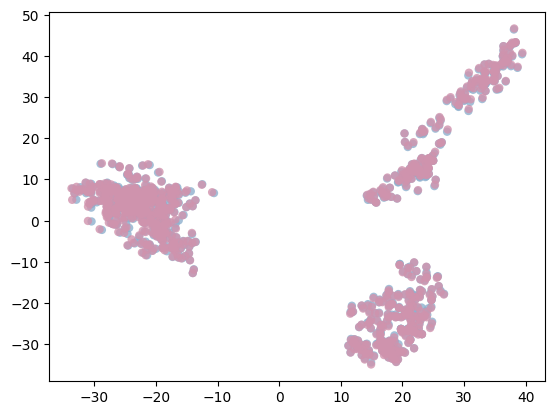

Divergence: 13.862234115600586
Baseline: 0.0
% Divergence: 1386223.4115600586
Expl Var: -0.9033799767494202





In [34]:
layer = 7
pos_offset = 0
base = base_hstates

print("Layer:", layer)
print("Pos Offset:", pos_offset)
layers[:] = layer
rows = torch.arange(len(base_hstates)).long()
natty_states = base[rows,layers,positions+pos_offset]
intrv_states = intrv_hstates[rows,layers,positions+pos_offset]
print("Natty PCA")
X = np.concatenate([
    natty_states.clone().detach().cpu().float().numpy(),
    intrv_states.clone().detach().cpu().float().numpy(),
], axis=0)
train_X = X
mu = train_X.mean(0)
sig = train_X.std(0)+1e-5
X = (X-mu)/(sig)
train_X = (train_X-mu)/(sig)
pca = PCA()
pca.fit(train_X)

vecs = pca.transform(X)
natty_vecs = torch.tensor(vecs[:len(natty_states)])
intrv_vecs = torch.tensor(vecs[len(natty_states):])
diffs = torch.tensor([((natty_vecs[:,pc]-intrv_vecs[:,pc])**2).mean().item() for pc in range(natty_vecs.shape[1])])
args = torch.topk(diffs, 2).indices

pc0 = 0 #args[0]
pc1 = 1 #args[1]
print("PCS:", pc0, pc1)
print("expl var:", pca.explained_variance_ratio_[pc0], pca.explained_variance_ratio_[pc1])


natty_df = {
    "pc0": natty_vecs[:,pc0],
    "pc1": natty_vecs[:,pc1],
    "hue": np.ones_like(natty_vecs[:,1]),
}
intrv_df = {
    "pc0": intrv_vecs[:,pc0],
    "pc1": intrv_vecs[:,pc1],
    "hue": np.ones_like(natty_vecs[:,1]),
}


interleave_scatter(
    natty_df,
    intrv_df,
    hue=None,
    title="", #f"Neural Space {varb}",
    incl_legend=False,
    #save_name=os.path.join(
    #    "./", f"attn_head_deviation.png",
    #)
)

perm = torch.randperm(len(natty_vecs)).long()
div = get_emd(natty_vecs, intrv_vecs)
baseline = get_emd(natty_vecs[perm[:len(natty_vecs)//2]], natty_vecs[perm[len(natty_vecs)//2:]]) 
baseline = get_emd(natty_vecs, natty_vecs) 
div_fraction = (div-baseline)/(baseline+1e-5)
ev = explained_variance(natty_vecs, intrv_vecs).mean().item()
print("Divergence:", div)
print("Baseline:", baseline)
print("% Divergence:", div_fraction)
print("Expl Var:", ev)
print()
print()
print()



In [25]:
torch.topk(torch.arange(4), 2).indices

tensor([3, 2])

Layer: 1
Pos Offset: 0
Natty PCA


/home/grantsrb/src/pyvene_fork/tutorials/advanced_tutorials/plotting_utils.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/tutorials/advanced_tutorials/plotting_utils.py:53: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/tutorials/advanced_tutorials/plotting_utils.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


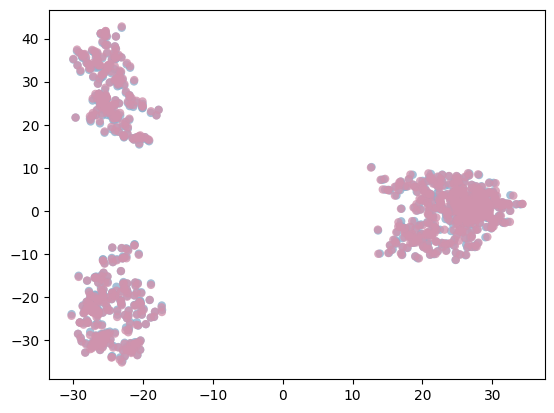

Divergence: 15.542625427246094
Baseline: 0.0
% Divergence: 1554262.5427246091
Expl Var: -0.8966876268386841



Layer: 1
Pos Offset: 1
Natty PCA


/home/grantsrb/src/pyvene_fork/tutorials/advanced_tutorials/plotting_utils.py:47: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=intrv_df, ax=ax, hue=hue, palette=intrv_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/tutorials/advanced_tutorials/plotting_utils.py:53: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x="pc0", y="pc1", color=color, alpha=alpha, data=natty_df, ax=ax, hue=hue, palette=native_cmap, edgecolor="none")
/home/grantsrb/src/pyvene_fork/tutorials/advanced_tutorials/plotting_utils.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


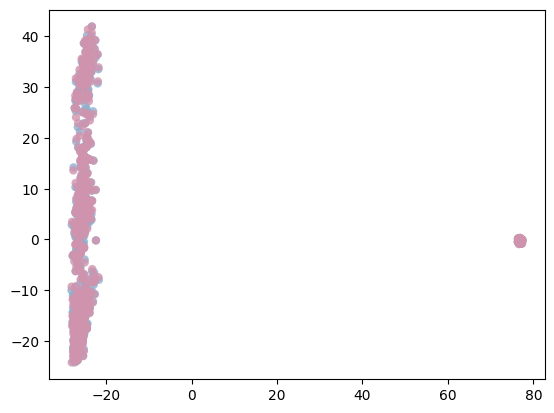

Divergence: 27.414920806884766
Baseline: 0.0
% Divergence: 2741492.0806884766
Expl Var: -0.6626796722412109



Layer: 1
Pos Offset: 2
Natty PCA


KeyboardInterrupt: 

In [8]:

#for pos_offset in range(20):
for layer in range(1,base_hstates.shape[1]):
    for pos_offset in range(20):
        print("Layer:", layer)
        print("Pos Offset:", pos_offset)
        layers[:] = layer
        rows = torch.arange(len(base_hstates)).long()
        natty_states = base_hstates[rows,layers,positions+pos_offset]
        intrv_states = intrv_hstates[rows,layers,positions+pos_offset]
        print("Natty PCA")
        X = np.concatenate([
            natty_states.clone().detach().cpu().float().numpy(),
            intrv_states.clone().detach().cpu().float().numpy(),
        ], axis=0)
        train_X = X
        mu = train_X.mean(0)
        sig = train_X.std(0)+1e-5
        X = (X-mu)/(sig)
        train_X = (train_X-mu)/(sig)
        pca = PCA()
        pca.fit(train_X)
        
        vecs = pca.transform(X)
        natty_vecs = torch.tensor(vecs[:len(natty_states)])
        intrv_vecs = torch.tensor(vecs[len(natty_states):])
        
        natty_df = {
            "pc0": natty_vecs[:,0],
            "pc1": natty_vecs[:,1],
            "hue": np.ones_like(natty_vecs[:,1]),
        }
        intrv_df = {
            "pc0": intrv_vecs[:,0],
            "pc1": intrv_vecs[:,1],
            "hue": np.ones_like(natty_vecs[:,1]),
        }
        
        
        interleave_scatter(
            natty_df,
            intrv_df,
            hue=None,
            title="", #f"Neural Space {varb}",
            incl_legend=False,
            #save_name=os.path.join(
            #    "./", f"attn_head_deviation.png",
            #)
        )
        
        perm = torch.randperm(len(natty_vecs)).long()
        div = get_emd(natty_vecs, intrv_vecs)
        baseline = get_emd(natty_vecs[perm[:len(natty_vecs)//2]], natty_vecs[perm[len(natty_vecs)//2:]]) 
        baseline = get_emd(natty_vecs, natty_vecs) 
        div_fraction = (div-baseline)/(baseline+1e-5)
        ev = explained_variance(natty_vecs, intrv_vecs).mean().item()
        print("Divergence:", div)
        print("Baseline:", baseline)
        print("% Divergence:", div_fraction)
        print("Expl Var:", ev)
        print()
        print()
        print()
        
        